#                     Cardiotocography dataset: Machine learning

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn
from sklearn import preprocessing, metrics
from keras import utils as np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from keras.layers import Dropout
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

seed = 42 #for reproducibility

   Medical difficulties and mortality associated with pregnancy are a major concern worldwide. Maternal mortality is very high in many parts of the world. Women die as a result of pregnancy-related complications, including maternal hemorrhage, abortion difficulties, high blood pressure, maternal infection, and obstructed labor.
   The dataset viewed in the project consists of measurements of fetal heart rate and uterine contraction features on cardiotocograms classified by expert obstetricians. The cardiotocography(CTG) is a commonly used technical method for 
constantly monitoring and recording the fetal heart rate and uterine contractions during pregnancy in order to evaluate fetal well-being and diagnose an increased risk of pregnancy problems. 
   This allows the monitoring and early intervention of embryonic hypoxia before severe asphyxia or death. During uterine contractions, the FHR and its variability, responsiveness, and probable decelerations are key indications of fetal well-being. 

# Load the data

In [3]:
ctg = pd.read_csv(('fetal_health.csv.csv'), sep=";") #Loading our data.

In [4]:
ctg.shape #Display the shape of our dataset.

(2126, 22)

In [5]:
ctg.info() #Display a concise summary of our Dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [6]:
print("Number of missing values: ", ctg.isnull().sum().sum()) #our dataset has no missing values as seen before in the info.

Number of missing values:  0


In [7]:
ctg.describe() #Generate descriptive statistics.

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


We notice that the range of values varies a lot among features. This characteristic may cause the classifiers that rely on the calculation of some form of distance to take decisions on how to split data to perform poorly. If a value range changes too much among features it is possible that significant variations in a feature with small range are not taken into account by the classifier because it is being concealed by a small change in a wide range one.

# Visualization

In [8]:
normal_values = ctg[ctg.fetal_health == 1.0] #keep the values that are normal = 1.0
normal_values.shape

(1655, 22)

In [9]:
suspect_values = ctg[ctg.fetal_health == 2.0] #keep the values that are suspect = 2.0
suspect_values.shape

(295, 22)

In [10]:
pathologic_values = ctg[ctg.fetal_health == 3.0] #keep the calues that are pathologic = 3.0
pathologic_values.shape

(176, 22)

In [11]:
fh = ctg.copy()

In [12]:
for col in fh.columns:
    print(col, ":", fh[col].value_counts().nunique())

baseline value : 40
accelerations : 20
fetal_movement : 21
uterine_contractions : 14
light_decelerations : 16
severe_decelerations : 2
prolongued_decelerations : 6
abnormal_short_term_variability : 41
mean_value_of_short_term_variability : 34
percentage_of_time_with_abnormal_long_term_variability : 28
mean_value_of_long_term_variability : 26
histogram_width : 30
histogram_min : 42
histogram_max : 47
histogram_number_of_peaks : 17
histogram_number_of_zeroes : 6
histogram_mode : 44
histogram_mean : 44
histogram_median : 38
histogram_variance : 40
histogram_tendency : 3
fetal_health : 3


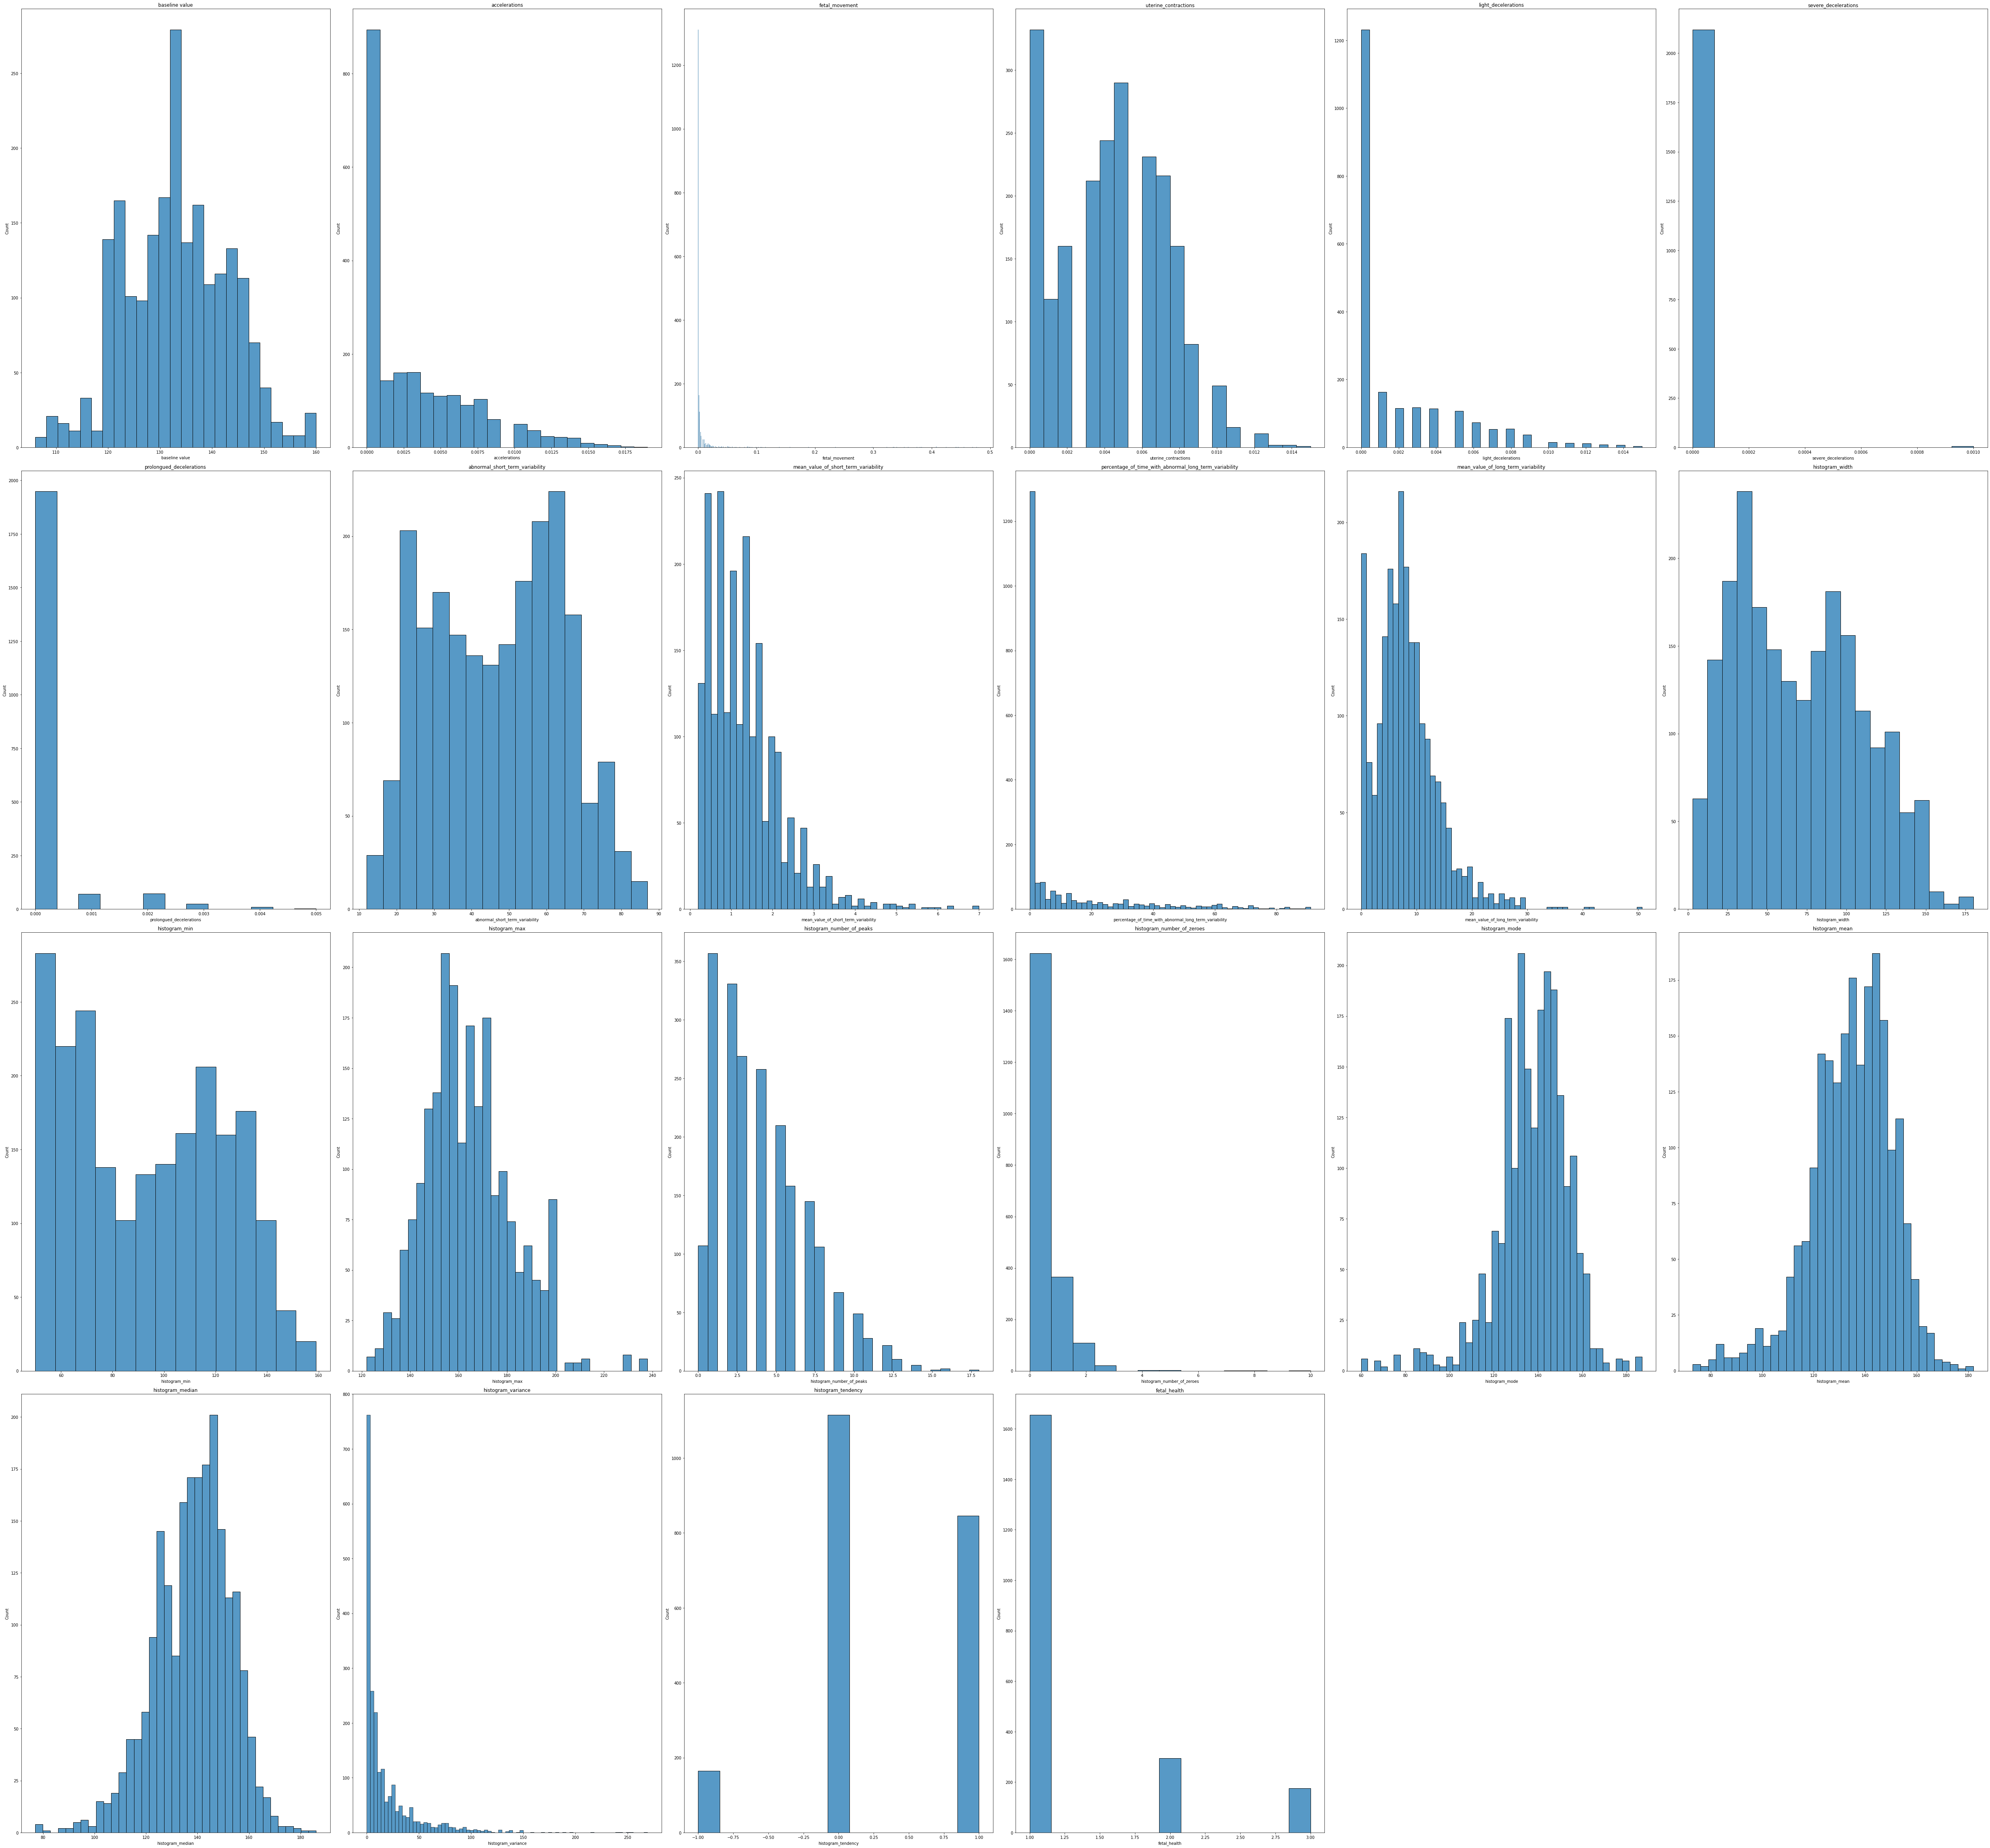

In [13]:
# Plot a histogram for each variable
plt.figure(figsize=(70, 65))
for i, column in enumerate(fh.columns):
    plt.subplot(4, 6, i + 1)
    sns.histplot(data=fh[column], palette='vlag')
    plt.title(column)
plt.tight_layout()
plt.show()

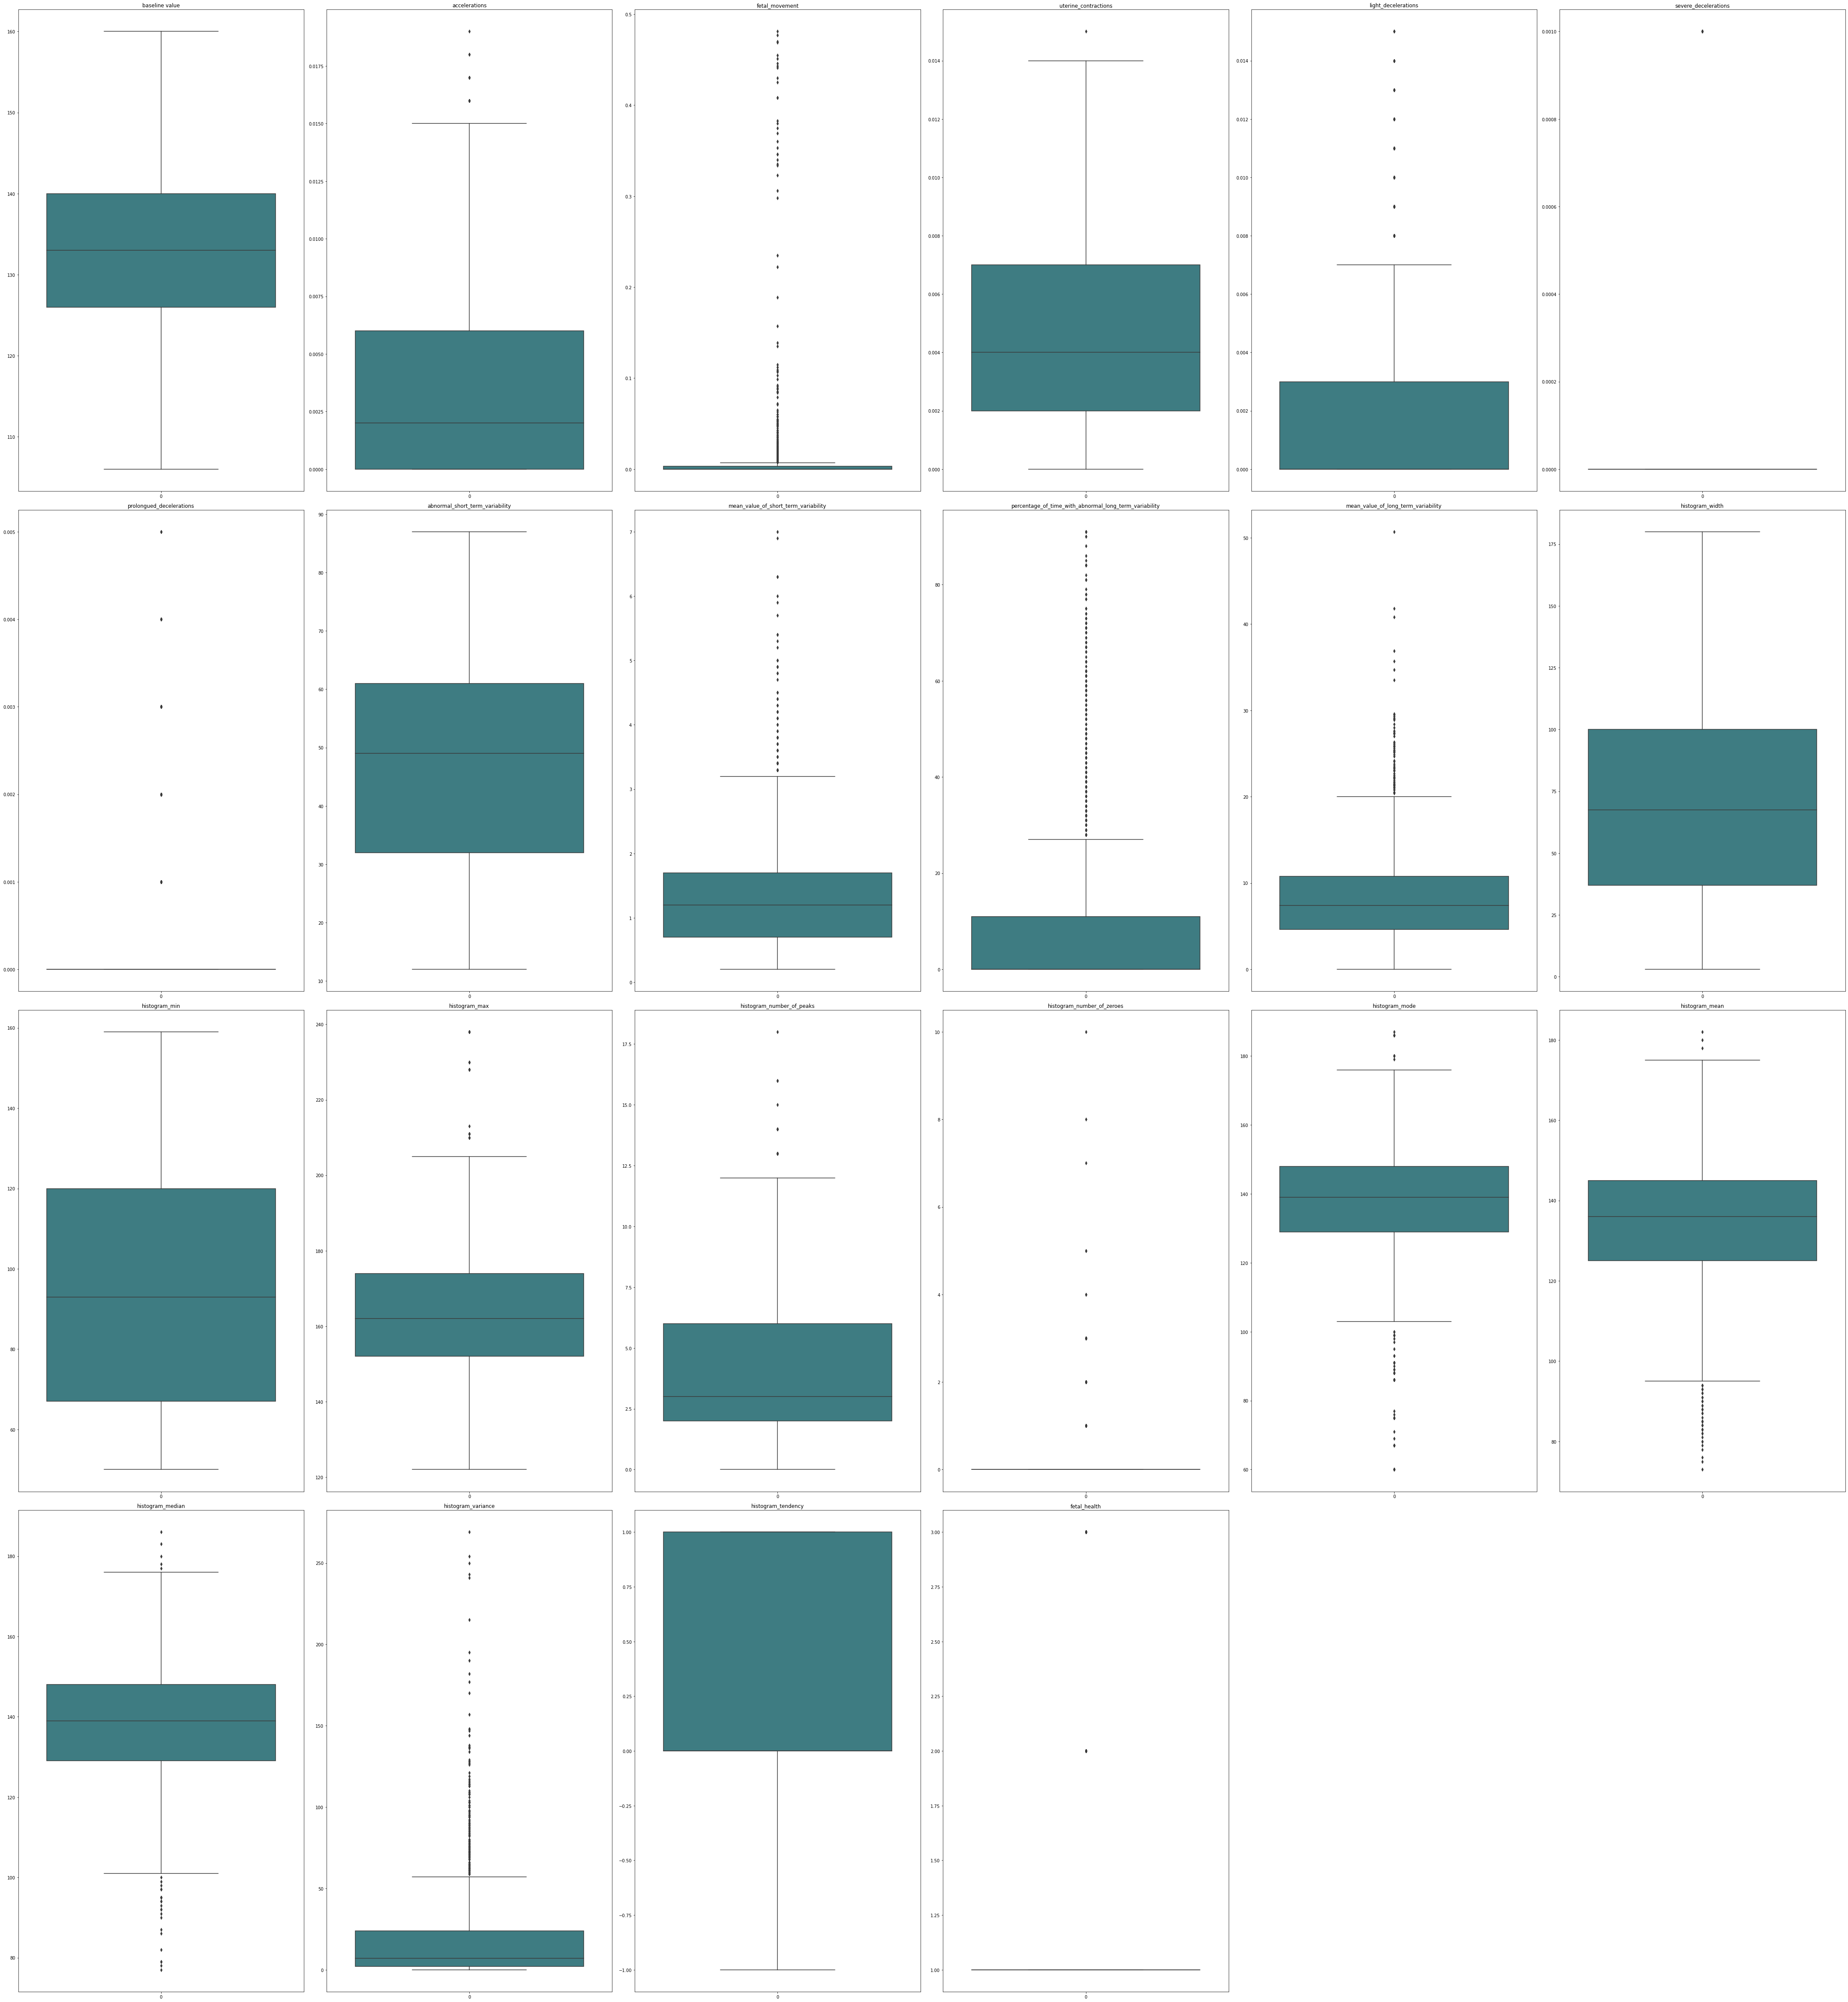

In [14]:
# Display the distribution of the values for each variable
plt.figure(figsize=(60, 65))
for i, column in enumerate(fh.columns):
    plt.subplot(4, 6, i + 1)
    sns.boxplot(data=fh[column], palette='crest')
    plt.title(column)
plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Fetal Health')]

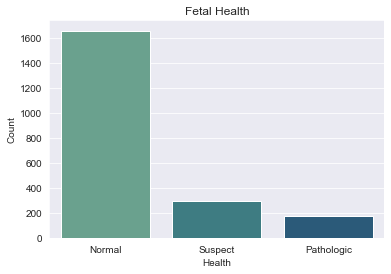

In [15]:
# Figure 1
sns.set_style("darkgrid")
fetalhealth = pd.DataFrame({'Health': ['Normal', 'Suspect', 'Pathologic'],
                            'Count': [normal_values['fetal_health'].count(), suspect_values['fetal_health'].count(), 
                                      pathologic_values['fetal_health'].count()]})
sns.barplot(x = 'Health', y = 'Count', data=fetalhealth, palette='crest').set(title="Fetal Health")

We notice that the dataset is imbalanced. Almost 80% of our dataset's samples are "normal values". This is not surprising given that these data are a sample of a real distribution of health conditions. A disease normally affects only a small part of the population while the majority are healthy.

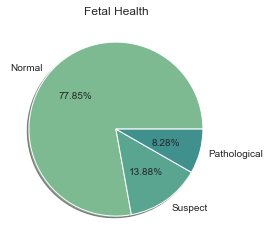

In [16]:
# Figure 2
plt.figure(figsize=plt.figaspect(1))
plt.pie(fh['fetal_health'].value_counts(),
       autopct='%.2f%%',
       labels=['Normal', 'Suspect', 'Pathological'],
       colors=sns.color_palette("crest"),
       shadow=True)
plt.title('Fetal Health')
plt.show()

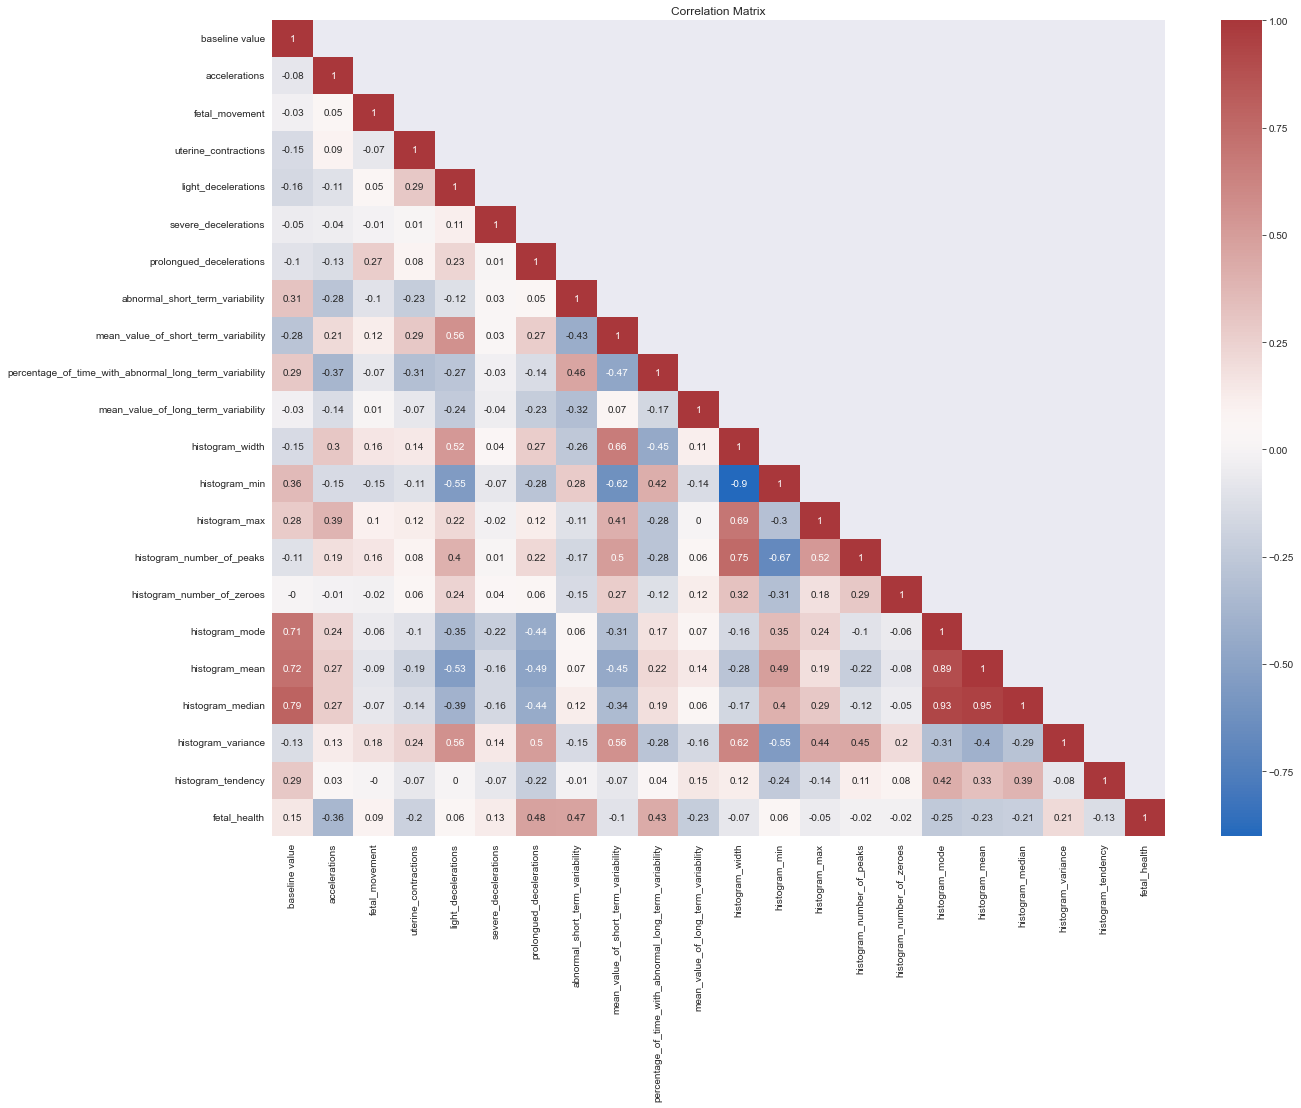

In [17]:
# Correlations between the variables.
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
corr = fh.corr()
corr = corr.round(decimals=2)
corr = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool_))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax, cmap='vlag')
plt.xticks(rotation=90)
plt.title("Correlation Matrix")
plt.show()

In the correlation matrix we observe how much two variables vary linearly toghether:

+1: total positive correlation, meaning they grow and decrease together,

0: no correlation

-1: total negative correlation, meaning when one grows the other decreases and vice versa.

If correlation is strong some features could be dropped because the majority of their information is de facto carried by the one they are strictly correlated to. Features that have a correlation above 0.9: mode has a positive correlation with median and mean, and min and width have negative correlation.

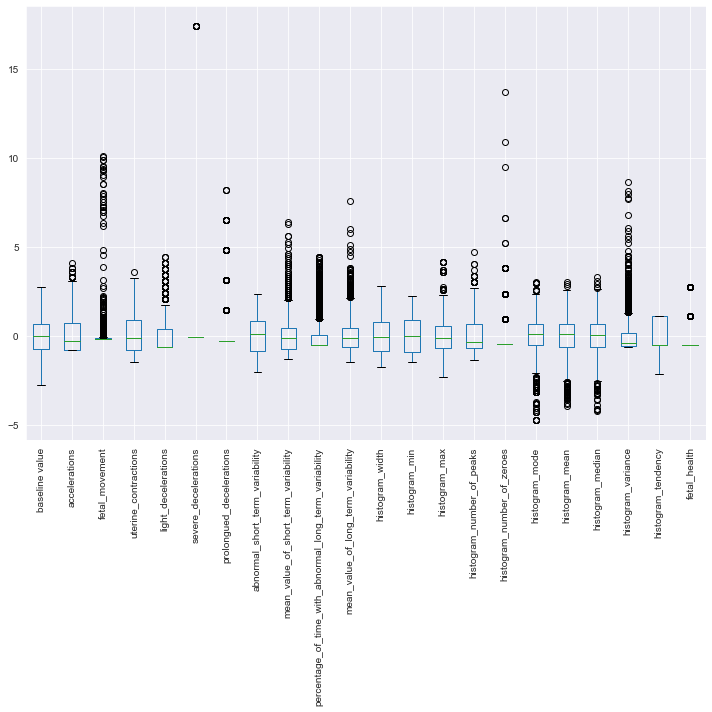

In [18]:
# Boxplots for feature distributions
fig, ax = plt.subplots(figsize=(10, 10))
fh_scale = pd.DataFrame(sklearn.preprocessing.scale(fh), columns=fh.columns)
fh_scale.boxplot(ax=ax, rot=90)
plt.tight_layout()
plt.show()

   An important problem in a medical monitoring is an error by measurement. As we can see, there are quite a few observations where a feature value is more than five standard deviations away from the feature mean. These outliers might represent instrument error, but they might also be caused by fat-tails of the true distributions, in which case these values are informative. If the outliers are errors, this can negatively impact the performance of our classifiers.

In [19]:
# Columns for detailed visualisation
columns = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability']

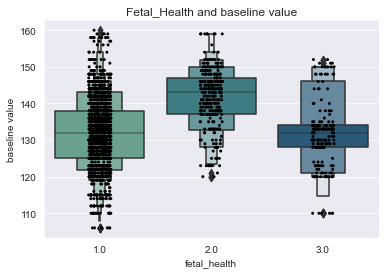

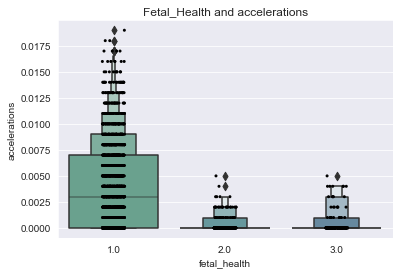

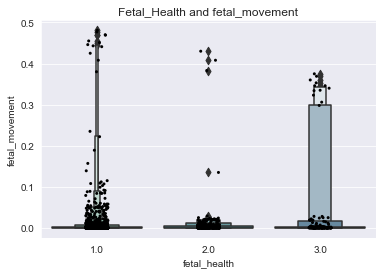

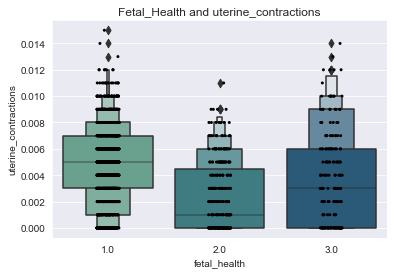

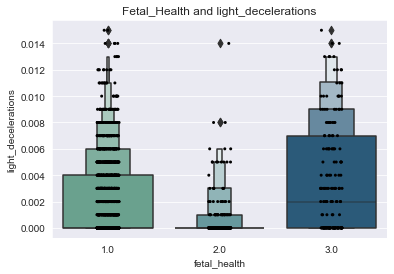

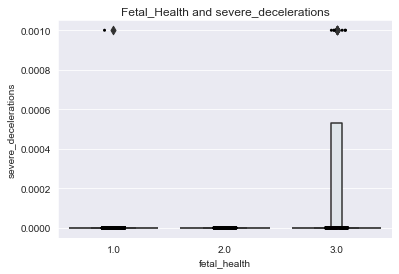

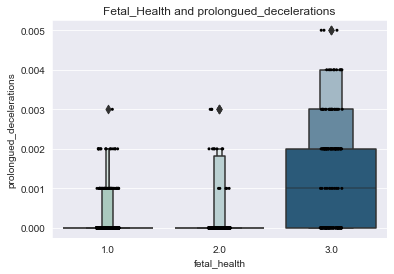

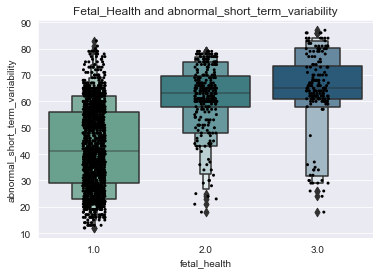

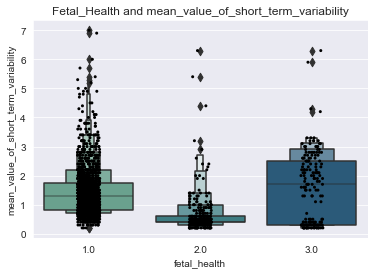

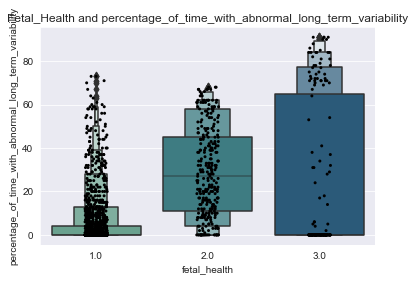

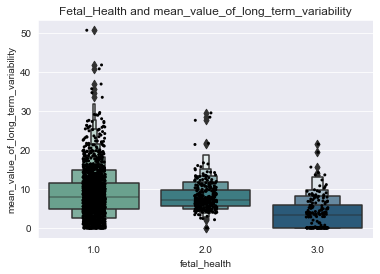

In [20]:
for i in columns:
    sns.stripplot(x=fh["fetal_health"], y=fh[i], size = 3, color = 'black')
    sns.boxenplot(x=fh["fetal_health"], y=fh[i], palette="crest")
    plt.title("Fetal_Health and " + i)
    plt.show()

   We can easily spot the outliers. However in this case, this is the outcome of a CTG report so it is unlikely that this was a data entry error.

# Preprocessing the data

In [21]:
X = fh.drop(['fetal_health'], axis=1)
y = fh['fetal_health']

In [22]:
# Encode class values and perform one-hot-encoding
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_en = np_utils.to_categorical(y)
print(y_en)
y_en.shape

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


(2126, 3)

In [23]:
Y = pd.DataFrame(y)

In [24]:
# Split our data into train and test sets(of our initial data)
X_train, X_test, y_train, y_test = train_test_split(X, y_en, test_size=0.3, random_state=seed)

In [25]:
# Split our data into train and test sets(of our standardize data)
X_train_std, X_test_std, y_train, y_test = train_test_split(X, y_en, test_size=0.3, random_state=seed)

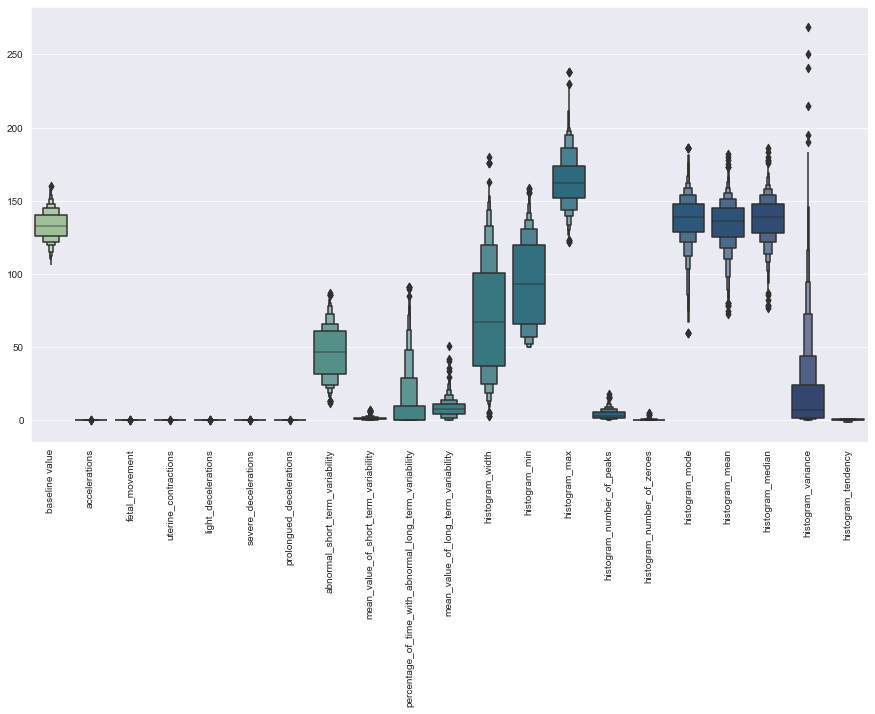

In [26]:
# Plot for feature distribution.
plt.figure(figsize = (10,7))
sns.boxenplot(data = X_train_std, palette = "crest")
plt.xticks(rotation = 90)
plt.show()

   It is neseccary to see the range of distribution for each of our feature attributes before fitting in a model. All the features are in different ranges, so we must scale them to the same range.

In [49]:
# Setting up a standard scaler for the features, because we are keeping the outliers we choose better the standardization
# of our dataset.
lc1 = list(X_train_std.columns)
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train_std)
X_train_std = pd.DataFrame(X_train_std, columns=lc1)

lc2 = list(X_test_std.columns)
scaler = preprocessing.StandardScaler()
X_test_std = scaler.fit_transform(X_test_std)
X_test_std = pd.DataFrame(X_test_std, columns=lc2)


In [1]:
plt.figure(figsize=(10, 7))
sns.boxenplot(data = X_train_std, palette = 'crest')
plt.xticks(rotation=90)
plt.show()

NameError: name 'plt' is not defined

# Linear Model 

In [29]:
# Building and fitting a Linear Regression model
def run_linear(X_train, X_test, y_train, y_test):
    linearModel = LinearRegression()
    linearModel.fit(X_train, y_train)
    print("Score:", linearModel.score(X_test, y_test))
    print("Intercept:", linearModel.intercept_)
    return linearModel

In [30]:
ml1 = run_linear(X_train, X_test, y_train, y_test)

Score: 0.41610248885859275
Intercept: [ 1.87624324 -0.91851507  0.03447314]


In [31]:
ml2 = run_linear(X_train_std, X_test_std, y_train, y_test)

Score: 0.41556103670749245
Intercept: [0.77889785 0.13037634 0.09072581]


In [33]:
y_pred1 = ml1.predict(X_test)

# calculate MAE, MSE, RMSE
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

Mean Absolute Error: 0.18805736483902213
Mean Squared Error: 0.06966789520484738
Root Mean Squared Error: 0.2639467658541157


# Neural Network Model

In [34]:
# Model
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer_function = tf.keras.optimizers.SGD(learning_rate=0.01)
metric = 'accuracy'
activation_function = 'softmax' # Because it is multi-class,'softmax' was selected as the activation function.

tf.random.set_seed(seed)

def run(X_train, X_test, y_train, y_test):
    model_l = tf.keras.Sequential([tf.keras.layers.Dense(3, activation=activation_function, input_shape=(X_train.shape[1],))])
    model_l.compile(loss = loss_function,
                 optimizer = optimizer_function,
                 metrics = [metric])
    model_l.fit(X_train, y_train, epochs = 50, validation_data=(X_test, y_test), verbose=1)
    score = model_l.evaluate(X_test, y_test)
    
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    
    y_predl = model_l.predict(X_test)
    y_pred_idc = np.argmax(y_predl, axis=1)
    y_idc = np.argmax(y_test, axis=1)
    result = tf.math.confusion_matrix(y_idc, y_pred_idc)
    print(result)

In [35]:
# Run the model with the initial data
run(X_train, X_test, y_train, y_test)

Epoch 1/50
47/47 [==============================] - 0s 3ms/step - loss: 161.9897 - accuracy: 0.6559 - val_loss: 22.3236 - val_accuracy: 0.8119
Epoch 2/50
47/47 [==============================] - 0s 1ms/step - loss: 105.5587 - accuracy: 0.6774 - val_loss: 163.1430 - val_accuracy: 0.3276
Epoch 3/50
47/47 [==============================] - 0s 1ms/step - loss: 84.0849 - accuracy: 0.7157 - val_loss: 157.5335 - val_accuracy: 0.7853
Epoch 4/50
47/47 [==============================] - 0s 1ms/step - loss: 69.1047 - accuracy: 0.7594 - val_loss: 197.9559 - val_accuracy: 0.7806
Epoch 5/50
47/47 [==============================] - 0s 1ms/step - loss: 70.9875 - accuracy: 0.7601 - val_loss: 64.7742 - val_accuracy: 0.7915
Epoch 6/50
47/47 [==============================] - 0s 1ms/step - loss: 51.1883 - accuracy: 0.7708 - val_loss: 309.8880 - val_accuracy: 0.7806
Epoch 7/50
47/47 [==============================] - 0s 1ms/step - loss: 55.6790 - accuracy: 0.7823 - val_loss: 25.8966 - val_accuracy: 0.7994


In [36]:
# Run the linear model with the standardize data
run(X_train_std, X_test_std, y_train, y_test)

Epoch 1/50
47/47 [==============================] - 0s 3ms/step - loss: 1.5098 - accuracy: 0.4012 - val_loss: 1.2016 - val_accuracy: 0.4749
Epoch 2/50
47/47 [==============================] - 0s 1ms/step - loss: 1.1144 - accuracy: 0.5060 - val_loss: 0.9222 - val_accuracy: 0.5925
Epoch 3/50
47/47 [==============================] - 0s 1ms/step - loss: 0.8727 - accuracy: 0.6398 - val_loss: 0.7582 - val_accuracy: 0.7116
Epoch 4/50
47/47 [==============================] - 0s 1ms/step - loss: 0.7264 - accuracy: 0.7319 - val_loss: 0.6542 - val_accuracy: 0.7821
Epoch 5/50
47/47 [==============================] - 0s 1ms/step - loss: 0.6311 - accuracy: 0.7836 - val_loss: 0.5839 - val_accuracy: 0.8166
Epoch 6/50
47/47 [==============================] - 0s 1ms/step - loss: 0.5645 - accuracy: 0.8152 - val_loss: 0.5331 - val_accuracy: 0.8339
Epoch 7/50
47/47 [==============================] - 0s 1ms/step - loss: 0.5158 - accuracy: 0.8273 - val_loss: 0.4949 - val_accuracy: 0.8448
Epoch 8/50
47/47 [==

# Neural Network Model_1

In [37]:
# Model_1
def create_model(loss, optimizer):
    model = tf.keras.Sequential([tf.keras.layers.Dense(100, activation='ReLU', input_shape=(X_train_std.shape[1],)),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(100, activation='ReLU'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(100, activation='ReLU'),
                            tf.keras.layers.Dense(3, activation='softmax')])
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model
model_1 = create_model('categorical_crossentropy', tf.keras.optimizers.Adam(learning_rate=0.001)) 

In [38]:
history_1 = model_1.fit(X_train_std, y_train, epochs=200, batch_size=100, verbose=1, validation_data=(X_test_std, y_test))

Epoch 1/200
15/15 [==============================] - 0s 9ms/step - loss: 0.8318 - accuracy: 0.6794 - val_loss: 0.5794 - val_accuracy: 0.7774
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 0.5251 - accuracy: 0.8112 - val_loss: 0.4313 - val_accuracy: 0.8589
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.3987 - accuracy: 0.8454 - val_loss: 0.3555 - val_accuracy: 0.8621
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.3591 - accuracy: 0.8542 - val_loss: 0.3316 - val_accuracy: 0.8699
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8730 - val_loss: 0.3121 - val_accuracy: 0.8793
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.2950 - accuracy: 0.8770 - val_loss: 0.3009 - val_accuracy: 0.8824
Epoch 7/200
15/15 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.8824 - val_loss: 0.2903 - val_accuracy: 0.8918
Epoch 8/200
1

Epoch 59/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1199 - accuracy: 0.9456 - val_loss: 0.2293 - val_accuracy: 0.9107
Epoch 60/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9469 - val_loss: 0.2321 - val_accuracy: 0.9216
Epoch 61/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.9489 - val_loss: 0.2238 - val_accuracy: 0.9232
Epoch 62/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1211 - accuracy: 0.9462 - val_loss: 0.2336 - val_accuracy: 0.9185
Epoch 63/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1156 - accuracy: 0.9449 - val_loss: 0.2312 - val_accuracy: 0.9154
Epoch 64/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1055 - accuracy: 0.9624 - val_loss: 0.2286 - val_accuracy: 0.9122
Epoch 65/200
15/15 [==============================] - 0s 3ms/step - loss: 0.1179 - accuracy: 0.9536 - val_loss: 0.2271 - val_accuracy: 0.9169
Epoch 

15/15 [==============================] - 0s 3ms/step - loss: 0.0516 - accuracy: 0.9785 - val_loss: 0.3215 - val_accuracy: 0.9232
Epoch 174/200
15/15 [==============================] - 0s 3ms/step - loss: 0.0532 - accuracy: 0.9819 - val_loss: 0.3093 - val_accuracy: 0.9279
Epoch 175/200
15/15 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9866 - val_loss: 0.3152 - val_accuracy: 0.9326
Epoch 176/200
15/15 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9819 - val_loss: 0.3122 - val_accuracy: 0.9326
Epoch 177/200
15/15 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9852 - val_loss: 0.3201 - val_accuracy: 0.9295
Epoch 178/200
15/15 [==============================] - 0s 3ms/step - loss: 0.0491 - accuracy: 0.9812 - val_loss: 0.3372 - val_accuracy: 0.9263
Epoch 179/200
15/15 [==============================] - 0s 3ms/step - loss: 0.0448 - accuracy: 0.9819 - val_loss: 0.3337 - val_accuracy: 0.9279
Epoch 180/200

In [39]:
score = model_1.evaluate(X_test_std, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

20/20 [==============================] - 0s 632us/step - loss: 0.3222 - accuracy: 0.9279
Test loss: 0.3222254812717438
Test accuracy: 0.9278996586799622


In [40]:
y_pred_1 = model_1.predict(X_test_std)
y_pred_idc = np.argmax(y_pred_1, axis=1)
y_idc = np.argmax(y_test, axis=1)
result_1 = tf.math.confusion_matrix(y_idc, y_pred_idc)
print(result_1)

20/20 [==============================] - 0s 579us/step
tf.Tensor(
[[478  13   5]
 [ 19  79   3]
 [  3   3  35]], shape=(3, 3), dtype=int32)


In [41]:
# Function to plot loss during training
def plot_loss(model_fitting):
    plt.plot(model_fitting.history['loss'], label='train') 
    plt.plot(model_fitting.history['val_loss'], label='test')
    plt.title('Model Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss values')
    plt.legend(loc='upper right')
    plt.show()

In [42]:
# Function to plot accuracy measurements during training-testing
def plot_accuracy(model_fitting):
    plt.plot(model_fitting.history['accuracy'], label='train')
    plt.plot(model_fitting.history['val_accuracy'], label='test')
    plt.title('Model Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='upper right')
    plt.show()

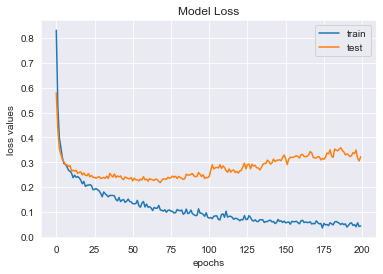

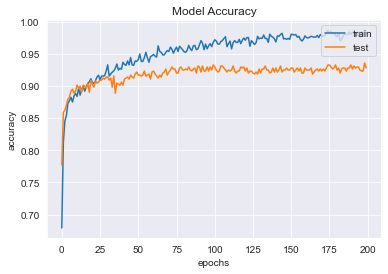

(None, None)

In [43]:
plot_loss(history_1), plot_accuracy(history_1)

# Neural Network Model_2

In [44]:
# Model_2
tf.random.set_seed(seed)

model_2 = tf.keras.Sequential([tf.keras.layers.Dense(100, activation='ReLU', input_shape=(X_train_std.shape[1],)),
                            tf.keras.layers.Dense(100, activation='ReLU'),
                            tf.keras.layers.Dense(100, activation='ReLU'),
                            tf.keras.layers.Dense(100, activation='ReLU'),
                            tf.keras.layers.Dense(3, activation='softmax')])
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics = ['accuracy'])
history_2 = model_2.fit(X_train_std, y_train, epochs = 100, batch_size=128, validation_data=(X_test_std, y_test), verbose=1)
score_2 = model_2.evaluate(X_test_std, y_test)
print("Test loss:", score_2[0])
print("Test accuracy:", score_2[1])

y_pred_2 = model_2.predict(X_test_std)
y_pred_idc = np.argmax(y_pred_2, axis=1)
y_idc = np.argmax(y_test, axis=1)
result_2 = tf.math.confusion_matrix(y_idc, y_pred_idc)
print(result_2)

Epoch 1/100
12/12 [==============================] - 0s 11ms/step - loss: 0.7713 - accuracy: 0.7554 - val_loss: 0.5463 - val_accuracy: 0.7774
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.4308 - accuracy: 0.8427 - val_loss: 0.3578 - val_accuracy: 0.8699
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2988 - accuracy: 0.8824 - val_loss: 0.2934 - val_accuracy: 0.8887
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.8972 - val_loss: 0.2742 - val_accuracy: 0.8903
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2278 - accuracy: 0.9039 - val_loss: 0.2473 - val_accuracy: 0.8887
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2119 - accuracy: 0.9052 - val_loss: 0.2370 - val_accuracy: 0.8997
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1922 - accuracy: 0.9120 - val_loss: 0.2351 - val_accuracy: 0.9060
Epoch 8/100


Epoch 59/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9913 - val_loss: 0.3974 - val_accuracy: 0.9169
Epoch 60/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9879 - val_loss: 0.3945 - val_accuracy: 0.9201
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.9946 - val_loss: 0.3516 - val_accuracy: 0.9263
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9933 - val_loss: 0.3499 - val_accuracy: 0.9279
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.3583 - val_accuracy: 0.9248
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.3818 - val_accuracy: 0.9310
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 0.3663 - val_accuracy: 0.9232
Epoch 

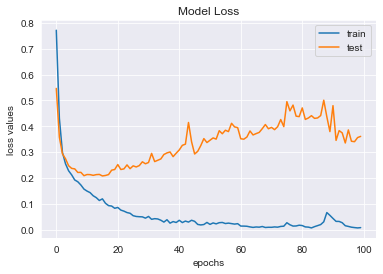

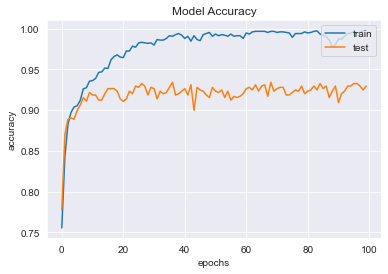

(None, None)

In [45]:
plot_loss(history_2), plot_accuracy(history_2)

   We notice that our model is overfitting because the validation loss is worse than the training loss. As we use more epochs, the validation loss starts getting higher values while the training loss keeps getting lower values. The model is unable to generalize well, meaning that it's learned the features of the training set extremely well but if we give the model 
any data that slightly deviates from the exact data used during training it's unable to generalize and accurately predict the output.

# Neural Network Model_3

In [46]:
# Model_3-Dropout-L2
model_3 = tf.keras.Sequential([tf.keras.layers.Dense(100, activation='ReLU', input_shape=(X_train_std.shape[1],), kernel_regularizer='l2'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(100, activation='ReLU', kernel_regularizer='l2'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(100, activation='ReLU', kernel_regularizer='l2'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(100, activation='ReLU', kernel_regularizer='l2'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer='l2')])
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics = ['accuracy'])
history_3 = model_3.fit(X_train_std, y_train, epochs = 200, batch_size=128, validation_data=(X_test_std, y_test), verbose=1)

Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 4.1301 - accuracy: 0.6922 - val_loss: 3.7080 - val_accuracy: 0.7774
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 3.5114 - accuracy: 0.7809 - val_loss: 3.1681 - val_accuracy: 0.8135
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 2.9835 - accuracy: 0.8219 - val_loss: 2.7245 - val_accuracy: 0.8715
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 2.5877 - accuracy: 0.8535 - val_loss: 2.3853 - val_accuracy: 0.8777
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 2.2730 - accuracy: 0.8696 - val_loss: 2.1049 - val_accuracy: 0.8856
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 1.9892 - accuracy: 0.8810 - val_loss: 1.8630 - val_accuracy: 0.8918
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 1.7542 - accuracy: 0.8844 - val_loss: 1.6515 - val_accuracy: 0.8918
Epoch 8/200


Epoch 59/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3861 - accuracy: 0.9046 - val_loss: 0.4085 - val_accuracy: 0.9075
Epoch 60/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3857 - accuracy: 0.9079 - val_loss: 0.4003 - val_accuracy: 0.9138
Epoch 61/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3733 - accuracy: 0.9133 - val_loss: 0.3927 - val_accuracy: 0.9091
Epoch 62/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3897 - accuracy: 0.9005 - val_loss: 0.4091 - val_accuracy: 0.9107
Epoch 63/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3778 - accuracy: 0.9059 - val_loss: 0.3945 - val_accuracy: 0.9075
Epoch 64/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3759 - accuracy: 0.9099 - val_loss: 0.3977 - val_accuracy: 0.9075
Epoch 65/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3817 - accuracy: 0.9126 - val_loss: 0.3984 - val_accuracy: 0.9044
Epoch 

12/12 [==============================] - 0s 4ms/step - loss: 0.3682 - accuracy: 0.9153 - val_loss: 0.3904 - val_accuracy: 0.8997
Epoch 174/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3711 - accuracy: 0.9046 - val_loss: 0.3788 - val_accuracy: 0.9060
Epoch 175/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3734 - accuracy: 0.9140 - val_loss: 0.3945 - val_accuracy: 0.9060
Epoch 176/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3621 - accuracy: 0.9153 - val_loss: 0.3818 - val_accuracy: 0.9122
Epoch 177/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3614 - accuracy: 0.9207 - val_loss: 0.3820 - val_accuracy: 0.9044
Epoch 178/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3636 - accuracy: 0.9106 - val_loss: 0.3782 - val_accuracy: 0.9107
Epoch 179/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3665 - accuracy: 0.9153 - val_loss: 0.3815 - val_accuracy: 0.9154
Epoch 180/200

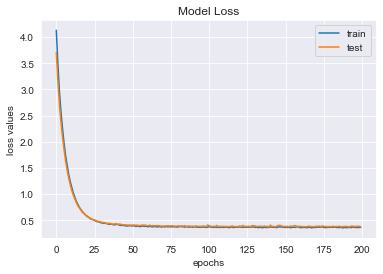

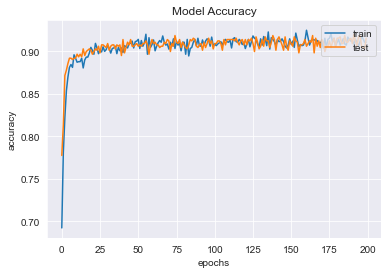

(None, None)

In [47]:
plot_loss(history_3), plot_accuracy(history_3)

We notice that the model doesn't overfit to the given values and as an outcome we achieve to averaging the results.
By removing different neurons on every pass through the network via dropout, the model won’t generalize to the test data.

# Neural Network Model_4-Implement sample weights

In [47]:
# Implement sample weights.
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.42795513373597927, 1: 2.556701030927835, 2: 3.674074074074074}

In [48]:
tf.random.set_seed(seed)

model_4 = tf.keras.Sequential([tf.keras.layers.Dense(200, activation='ReLU', input_shape=(X_train_std.shape[1],)),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(200, activation='ReLU'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(150, activation='ReLU'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(3, activation='softmax')])
model_4.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics = ['accuracy'])
history_4 = model_4.fit(X_train_std, y_train, epochs = 300, batch_size=60, validation_data=(X_test_std, y_test), verbose=1,
                       class_weight=class_weights_dict)
score_4 = model_4.evaluate(X_test_std, y_test)
print("Test loss:", score_4[0])
print("Test accuracy:", score_4[1])

y_pred_4 = model_4.predict(X_test_std)
y_pred_idc = np.argmax(y_pred_4, axis=1)
y_idc = np.argmax(y_test, axis=1)
result_4 = tf.math.confusion_matrix(y_idc, y_pred_idc)
print(result_4)

Epoch 1/300
25/25 [==============================] - 1s 9ms/step - loss: 1.0511 - accuracy: 0.3992 - val_loss: 1.0686 - val_accuracy: 0.3856
Epoch 2/300
25/25 [==============================] - 0s 4ms/step - loss: 0.9684 - accuracy: 0.4315 - val_loss: 1.0398 - val_accuracy: 0.4702
Epoch 3/300
25/25 [==============================] - 0s 4ms/step - loss: 0.8749 - accuracy: 0.5034 - val_loss: 0.9658 - val_accuracy: 0.5956
Epoch 4/300
25/25 [==============================] - 0s 4ms/step - loss: 0.8554 - accuracy: 0.5941 - val_loss: 0.9012 - val_accuracy: 0.6583
Epoch 5/300
25/25 [==============================] - 0s 4ms/step - loss: 0.7912 - accuracy: 0.6606 - val_loss: 0.8301 - val_accuracy: 0.7053
Epoch 6/300
25/25 [==============================] - 0s 4ms/step - loss: 0.7462 - accuracy: 0.6841 - val_loss: 0.7792 - val_accuracy: 0.7288
Epoch 7/300
25/25 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.7198 - val_loss: 0.7118 - val_accuracy: 0.7476
Epoch 8/300
2

Epoch 59/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3517 - accuracy: 0.8690 - val_loss: 0.3688 - val_accuracy: 0.8433
Epoch 60/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3492 - accuracy: 0.8696 - val_loss: 0.3748 - val_accuracy: 0.8401
Epoch 61/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3448 - accuracy: 0.8683 - val_loss: 0.3656 - val_accuracy: 0.8417
Epoch 62/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3249 - accuracy: 0.8710 - val_loss: 0.3729 - val_accuracy: 0.8433
Epoch 63/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3510 - accuracy: 0.8616 - val_loss: 0.3876 - val_accuracy: 0.8339
Epoch 64/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3395 - accuracy: 0.8609 - val_loss: 0.3700 - val_accuracy: 0.8448
Epoch 65/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3307 - accuracy: 0.8716 - val_loss: 0.3687 - val_accuracy: 0.8433
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.2211 - accuracy: 0.9086 - val_loss: 0.3032 - val_accuracy: 0.8652
Epoch 174/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1947 - accuracy: 0.9113 - val_loss: 0.2949 - val_accuracy: 0.8668
Epoch 175/300
25/25 [==============================] - 0s 4ms/step - loss: 0.2020 - accuracy: 0.9052 - val_loss: 0.3098 - val_accuracy: 0.8652
Epoch 176/300
25/25 [==============================] - 0s 4ms/step - loss: 0.2021 - accuracy: 0.9059 - val_loss: 0.3140 - val_accuracy: 0.8621
Epoch 177/300
25/25 [==============================] - 0s 4ms/step - loss: 0.2137 - accuracy: 0.9120 - val_loss: 0.3102 - val_accuracy: 0.8621
Epoch 178/300
25/25 [==============================] - 0s 4ms/step - loss: 0.2058 - accuracy: 0.9039 - val_loss: 0.3118 - val_accuracy: 0.8621
Epoch 179/300
25/25 [==============================] - 0s 4ms/step - loss: 0.2117 - accuracy: 0.9046 - val_loss: 0.3071 - val_accuracy: 0.8605
Epoch 180/300

25/25 [==============================] - 0s 4ms/step - loss: 0.1603 - accuracy: 0.9281 - val_loss: 0.2707 - val_accuracy: 0.8981
Epoch 288/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9288 - val_loss: 0.2742 - val_accuracy: 0.8934
Epoch 289/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1522 - accuracy: 0.9234 - val_loss: 0.2715 - val_accuracy: 0.8997
Epoch 290/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1580 - accuracy: 0.9241 - val_loss: 0.2598 - val_accuracy: 0.9028
Epoch 291/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1482 - accuracy: 0.9274 - val_loss: 0.2596 - val_accuracy: 0.9013
Epoch 292/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1698 - accuracy: 0.9267 - val_loss: 0.2667 - val_accuracy: 0.9044
Epoch 293/300
25/25 [==============================] - 0s 4ms/step - loss: 0.1495 - accuracy: 0.9335 - val_loss: 0.2725 - val_accuracy: 0.8950
Epoch 294/300

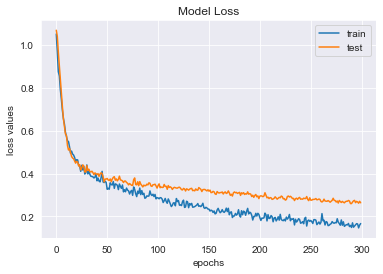

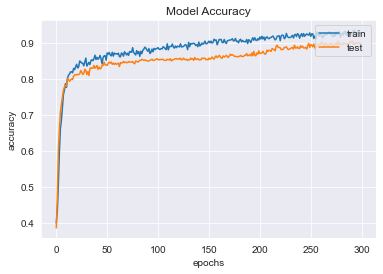

(None, None)

In [49]:
plot_loss(history_4), plot_accuracy(history_4)

By implementing weights to the classes we notice that the model can train equally to each class and thus we have a steady value loss through the epochs we use while at the same time a steady accuracy. Moreover, the model keeps on improving by using more epochs.

# Random Forest

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from sklearn import tree
from dtreeviz.trees import dtreeviz

In [51]:
predictions = defaultdict(list)

def RandomForest(model, X_train, y_train, X_test, y_test, title):
    model = model
    hist = model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    predictions[title].append(y_pred)
    print('Model accuracy score with 10 decision-trees: {0:0.4f}%'. format(accuracy_score(y_test, y_pred) * 100))
    
    target_names = ['Normal', 'Suspect', 'Pathologic']
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Normal', 'Actual Suspect', 'Actual Pathologic'], 
                                 index=['Predicted Normal', 'Predicted Suspect', 'Predicted Pathologic'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
    print('Confusion matrix:\n')
    return model

This model has an accuracy score of 93.4% on the test data. That seems pretty impressive compared to the other models, but the accuracy is not a great measure of classifier performance when the classes are imbalanced. In order to get more information and understand how well the model really performed, if it did perform equally well for each class, we use a confusion matrix.

Model accuracy score with 10 decision-trees: 93.4169%
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       496
     Suspect       0.92      0.75      0.83       101
  Pathologic       0.90      0.88      0.89        41

   micro avg       0.95      0.93      0.94       638
   macro avg       0.92      0.87      0.89       638
weighted avg       0.95      0.93      0.94       638
 samples avg       0.93      0.93      0.93       638

Confusion matrix:



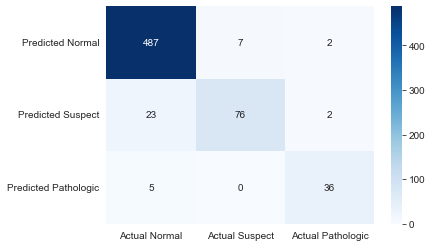

In [52]:
RF = RandomForest(RandomForestClassifier(random_state=seed), X_train, y_train, X_test, y_test, 'RF')

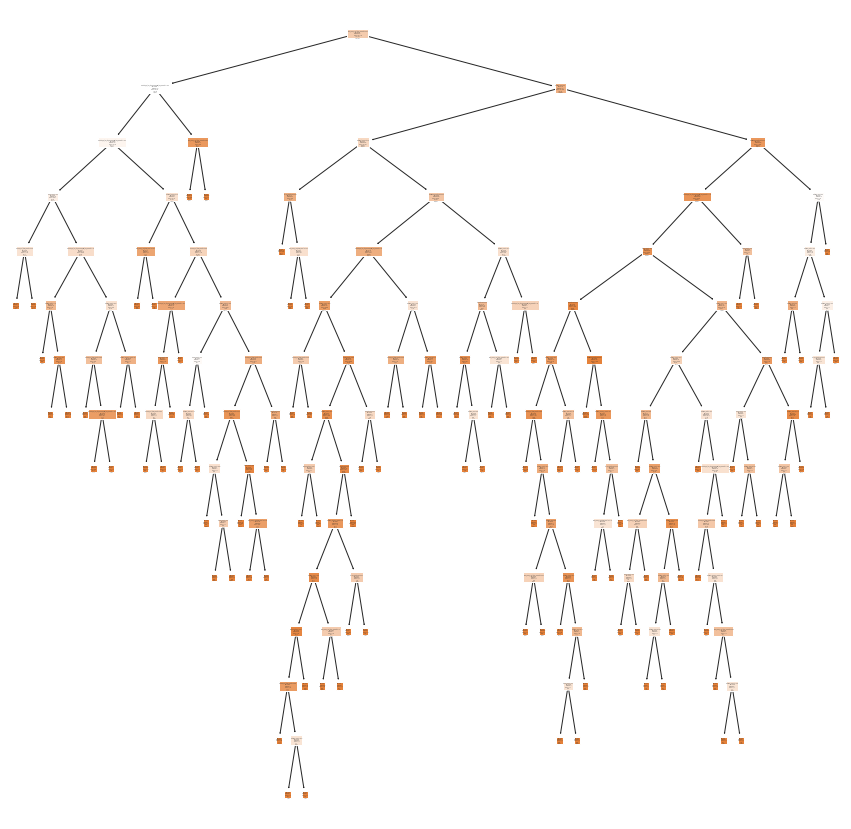

In [53]:
plt.figure(figsize=(15,15))
_ = tree.plot_tree(RF.estimators_[4], feature_names=X.columns, filled=True, impurity=True)

Model accuracy score with 10 decision-trees: 92.4765%
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       496
     Suspect       0.88      0.71      0.79       101
  Pathologic       0.87      0.83      0.85        41

   micro avg       0.94      0.92      0.93       638
   macro avg       0.90      0.84      0.87       638
weighted avg       0.94      0.92      0.93       638
 samples avg       0.92      0.92      0.92       638

Confusion matrix:



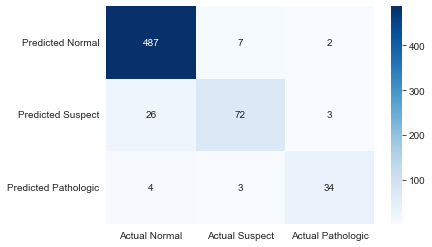

In [54]:
RF_std = RandomForest(RandomForestClassifier(random_state=seed), X_train_std, y_train, X_test_std, y_test, 'RF_std')

In [55]:
def PrintResults(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    
    Accuracy = accuracy_score(y_test, y_pred) * 100
    Precision = precision_score(y_test, y_pred, average='micro') * 100
    Recall = recall_score(y_test, y_pred, average='micro') * 100
    F1score = f1_score(y_test, y_pred, average='micro') * 100
    
    print(title, ":")
    print('Scoring Accuracy: %.3f %%' % (Accuracy))
    print("Precision: %.3f %%"%(Precision))
    print("Recall: %.3f %%"%(Recall))
    print('f1-score: %.3f %%'%(F1score))
      
    return model

For our dataset, we have to consider that achieving a high recall is more important than getting a high precision, because the goal is to detect as many fetals with suspect and pathological characteristics as possible.

In [56]:
PrintResults(RF, X_test, y_test, "Random Forest Classifier")

Random Forest Classifier :
Scoring Accuracy: 93.417 %
Precision: 94.904 %
Recall: 93.417 %
f1-score: 94.155 %


RandomForestClassifier(random_state=42)

With the simplest model of the Random Forest classifier we have so far the best results.

In [57]:
PrintResults(RF_std, X_test_std, y_test, "Random Forest Classifier with Standarized data")

Random Forest Classifier with Standarized data :
Scoring Accuracy: 92.476 %
Precision: 94.099 %
Recall: 92.476 %
f1-score: 93.281 %


RandomForestClassifier(random_state=42)

# Random Forest 2

In [58]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)
# Produce synthetic data to balance the classes.
sm = SMOTE(random_state=seed)
X_train_ov, y_train_ov = sm.fit_resample(X_train_ov, y_train_ov)
X_train_ov.shape, y_train_ov.shape

((3723, 21), (3723,))

In [59]:
# Function with different values for max depth.
training_loss = []
test_loss = []

def rf_score(i):
    rf = RandomForestClassifier(n_estimators=200, max_depth=i, min_samples_leaf=5, criterion='entropy',
                            n_jobs=-1, random_state=seed, bootstrap=True)
    rf.fit(X_train_ov, y_train_ov)
    
    y_pred_ov = rf.predict_proba(X_test_ov)
    y_pred_train_ov = rf.predict_proba(X_train_ov)
    training_loss.append(log_loss(y_train_ov, y_pred_train_ov))
    test_loss.append(log_loss(y_test_ov, y_pred_ov))
    
    print('For Max depth =', i , '--> Cross-Validation Score: ', np.mean(cross_val_score(rf, X_train_ov, y_train_ov)))

for i in range(1, 18):
    rf_score(i)

For Max depth = 1 --> Cross-Validation Score:  0.793443746842751
For Max depth = 2 --> Cross-Validation Score:  0.8353417045536551
For Max depth = 3 --> Cross-Validation Score:  0.897127444612831
For Max depth = 4 --> Cross-Validation Score:  0.9094843761275889
For Max depth = 5 --> Cross-Validation Score:  0.9299014938298333
For Max depth = 6 --> Cross-Validation Score:  0.9468221837338531
For Max depth = 7 --> Cross-Validation Score:  0.9578332250847946
For Max depth = 8 --> Cross-Validation Score:  0.9634740564335715
For Max depth = 9 --> Cross-Validation Score:  0.9661604243342715
For Max depth = 10 --> Cross-Validation Score:  0.9704560871761565
For Max depth = 11 --> Cross-Validation Score:  0.9726059031536407
For Max depth = 12 --> Cross-Validation Score:  0.9723370859493397
For Max depth = 13 --> Cross-Validation Score:  0.9731424550768566
For Max depth = 14 --> Cross-Validation Score:  0.9728743595294796
For Max depth = 15 --> Cross-Validation Score:  0.9728743595294796
For Ma

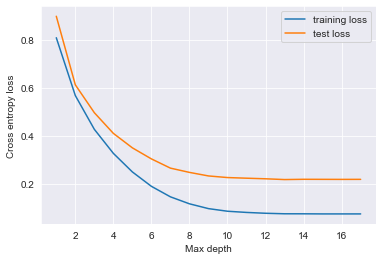

In [60]:
# Plot the Cross entropy loss for each value of 'max_depth' in the classifier.
l = range(1, 18)

plt.plot(l, training_loss, label="training loss")
plt.plot(l, test_loss, label="test loss")
plt.xlabel('Max depth')
plt.ylabel('Cross entropy loss')
plt.legend();

# Bayesian model

In [61]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

In [62]:
# Remove the outliers.
def fixoutliers(X):
    columnNames = X.columns
    for col in columnNames:
        xy = X[col]    

        updated = []
        Q1, Q3 = np.percentile(xy, [25, 75])
        IQR = Q3 - Q1
        minimum = Q1 - 2.0*IQR
        maximum = Q3 + 2.0*IQR
        for i in xy:
            if(i > maximum):
                i = maximum
                updated.append(i)
            elif(i < minimum):
                i = minimum
                updated.append(i)
            else:
                updated.append(i)
        X[col] = updated
    return X
X_fixed = fixoutliers(X)

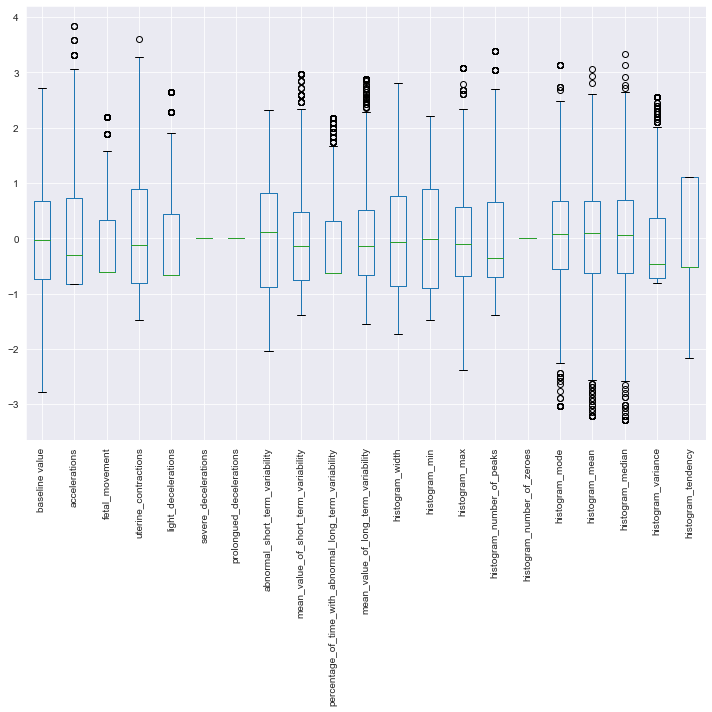

In [63]:
# Boxplots for feature distributions after removing the outliers.
fig, ax = plt.subplots(figsize=(10,10))
fh_scale = pd.DataFrame(sklearn.preprocessing.scale(X_fixed), columns=X.columns)
fh_scale.boxplot(ax=ax, rot=90)
plt.tight_layout()
plt.show()

In [66]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.25, random_state=seed)

# Dataset fixed from outliers.
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fixed, y, test_size=0.25, random_state=seed)

# Gaussian Naive Bayes

In [90]:
# Gaussian Naive Bayes.

def GNB(X_train, X_test, y_train, y_test):
    
    gnb = GaussianNB(priors=[0.77889785, 0.13037634, 0.09072581], var_smoothing=0.1)
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print('Model accuracy score: {0:0.3f}%'. format(accuracy_score(y_test, y_pred) * 100))
    print(metrics.classification_report(y_test, y_pred, zero_division=0))
    
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, cmap='GnBu', square=True, annot=True, cbar=False, fmt='d',
                xticklabels=['normal', 'suspect', 'pathologic'], 
                yticklabels=['normal', 'suspect', 'pathologic'])
    plt.xlabel('TRUE LABEL')
    plt.ylabel('PREDICTED LABEL');

Model accuracy score: 81.203%
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       413
           1       0.50      0.71      0.58        82
           2       0.70      0.51      0.59        37

    accuracy                           0.81       532
   macro avg       0.70      0.69      0.69       532
weighted avg       0.84      0.81      0.82       532



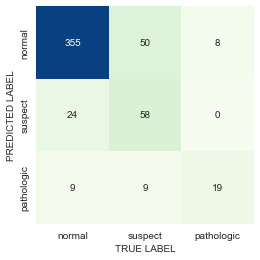

In [91]:
GNB1 = GNB(X_train_nb, X_test_nb, y_train_nb, y_test_nb)

Model accuracy score: 81.203%
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       413
           1       0.50      0.71      0.58        82
           2       0.70      0.51      0.59        37

    accuracy                           0.81       532
   macro avg       0.70      0.69      0.69       532
weighted avg       0.84      0.81      0.82       532



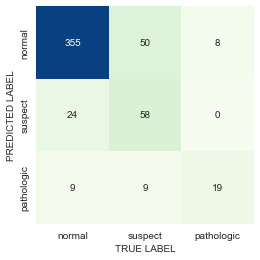

In [92]:
# Data fixed from outliers.
GNB1 = GNB(X_train_f, X_test_f, y_train_f, y_test_f)

Model accuracy score: 83.271%
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       414
           1       0.46      0.69      0.55        74
           2       0.82      0.52      0.64        44

    accuracy                           0.83       532
   macro avg       0.74      0.70      0.70       532
weighted avg       0.86      0.83      0.84       532



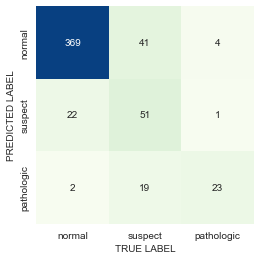

In [93]:
# Data with oversampling.
GNB3 = GNB(X_train_ov, X_test_ov, y_train_ov, y_test_ov)

# Multinomial Naive Bayes

In [82]:
# Multinomial Naive Bayes.

def MNB(X_train, X_test, y_train, y_test):
    
    mnb = MultinomialNB(class_prior=[0.5, 0.2, 0.3], alpha=2)
    p = make_pipeline(MinMaxScaler(), mnb)

    p.fit(X_train, y_train)
    y_pred = p.predict(X_test)
    print('Model accuracy score: {0:0.3f}%'. format(accuracy_score(y_test, y_pred) * 100))
    print(metrics.classification_report(y_test, y_pred, zero_division=0))
    
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, cmap='GnBu', square=True, annot=True, cbar=False, fmt='d',
                xticklabels=['normal', 'suspect', 'pathologic'], 
                yticklabels=['normal', 'suspect', 'pathologic'])
    plt.xlabel('TRUE LABEL')
    plt.ylabel('PREDICTED LABEL');

Model accuracy score: 81.391%
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       413
           1       0.55      0.73      0.62        82
           2       0.45      0.57      0.50        37

    accuracy                           0.81       532
   macro avg       0.64      0.72      0.67       532
weighted avg       0.84      0.81      0.82       532



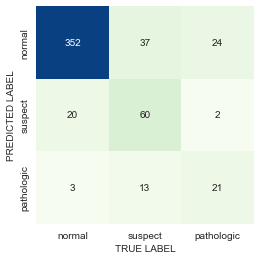

In [83]:
# Data fixed from outliers.
MNB1 = MNB(X_train_f, X_test_f, y_train_f, y_test_f)

Model accuracy score: 81.391%
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       413
           1       0.55      0.73      0.62        82
           2       0.45      0.57      0.50        37

    accuracy                           0.81       532
   macro avg       0.64      0.72      0.67       532
weighted avg       0.84      0.81      0.82       532



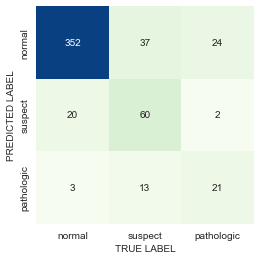

In [84]:
# Data used in the GaussianNB resulting to accuracy score: 81.203%.
MNB2 = MNB(X_train_nb, X_test_nb, y_train_nb, y_test_nb)

Model accuracy score: 83.647%
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       414
           1       0.49      0.47      0.48        74
           2       0.61      0.50      0.55        44

    accuracy                           0.84       532
   macro avg       0.67      0.64      0.65       532
weighted avg       0.83      0.84      0.83       532



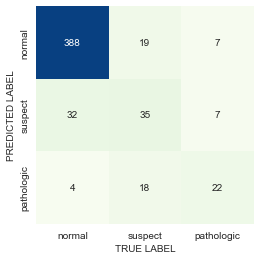

In [85]:
# Data with oversampling.
MNB3 = MNB(X_train_ov, X_test_ov, y_train_ov, y_test_ov)